In [1]:
# ============================================
# Cell 1 – Import libraries (Classification notebook)
# --------------------------------------------
# What this cell does:
# - Imports all Python libraries we need for:
#   * Data handling (NumPy, pandas)
#   * Splitting data into train / validation / test
#   * Preprocessing (scaling numeric features, encoding categorical features)
#   * Building pipelines (preprocess + model together)
#   * Evaluating classification performance
#   * Training 4 models on the SAME classification dataset:
#       - LinearSVC
#       - Logistic Regression (correct for classification)
# ============================================

import numpy as np  # NumPy: fast numerical operations and array handling
import pandas as pd  # pandas: work with tabular data (dataframes similar to Excel tables)

from sklearn.model_selection import train_test_split  # function to split data into train / validation / test sets

from sklearn.compose import ColumnTransformer  # lets us apply different preprocessing to different columns
from sklearn.preprocessing import OneHotEncoder  # transforms categorical (text) columns into numeric dummy variables
from sklearn.preprocessing import StandardScaler  # scales numeric features (mean 0, std 1), useful for KNN and logistic regression

from sklearn.pipeline import Pipeline  # allows us to chain preprocessing and model into one pipeline object

# ---- Classification metrics ----
from sklearn.metrics import accuracy_score  # basic classification metric: fraction of correct predictions
from sklearn.metrics import classification_report  # detailed classification metrics (precision, recall, f1-score for each class)

# ---- Models we will use on the CLASSIFICATION dataset ----
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression  # Logistic Regression model (well-suited for binary classification)


In [2]:
# ============================================
# Cell 2 – Load the Heart Disease dataset
# --------------------------------------------
# What this cell does:
# - Loads the dataset from the Kaggle input directory using the correct folder name.
# - Displays the first few rows to understand the structure.
# - Prints dataset shape, data types, and missing values.
# - Confirms that the target column (HeartDisease) exists and is binary.
# ============================================

# Load the dataset (replace folder name if yours is different)
df = pd.read_csv("heart.csv")
# ^ This file path works when the dataset folder is: heart-failure-prediction

# Show the first 5 rows
df.head()

# Print dataset shape (rows, columns)
print("Dataset shape:", df.shape)

# Show information about column types and non-null counts
df.info()

# Print missing values for each column
print("\nMissing values per column:")
print(df.isnull().sum())

# Set the target variable for classification
target = "HeartDisease"  # 1 = disease present, 0 = no disease

# Check uniqueness of the target values
print("\nTarget variable selected:", target)
print("Unique values in target:", df[target].unique())

Dataset shape: (918, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB

Missing values per column:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR    

In [3]:
# ============================================
# Cell 3 – Separate features & target, detect feature types
# --------------------------------------------
# What this cell does:
# - Splits the DataFrame into:
#     * X = input features (all columns except the target)
#     * y = target labels (HeartDisease)
# - Checks the distribution of the target (how many 0 vs 1).
# - Automatically detects:
#     * numeric feature columns
#     * categorical feature columns
# - Prints lists of numeric and categorical columns so we know
#   what will be scaled and what will be one-hot encoded later.
# ============================================

# Separate input features (X) and target labels (y)
X = df.drop(columns=[target])  # X = all columns except HeartDisease
y = df[target]                 # y = the HeartDisease column only

# Show basic information about the target distribution (class balance)
print("Target value counts (0 = no disease, 1 = disease):")
print(y.value_counts())

# Automatically detect numeric feature columns (int or float)
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
# Automatically detect categorical feature columns (non-numeric types)
categorical_features = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

print("\nNumeric feature columns:")
print(numeric_features)

print("\nCategorical feature columns:")
print(categorical_features)

Target value counts (0 = no disease, 1 = disease):
HeartDisease
1    508
0    410
Name: count, dtype: int64

Numeric feature columns:
['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

Categorical feature columns:
['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [4]:
# ============================================
# Cell 4 – Train / Validation / Test split (70% / 15% / 15%)
# --------------------------------------------
# What this cell does:
# - Splits our dataset into:
#       70% Training
#       15% Validation
#       15% Test
# - We first split out 15% for the TEST set.
# - Then from the remaining 85%, we calculate how much to split
#   to produce exactly 15% VALIDATION overall.
# - We use stratify=y to keep the same class balance (0/1)
#   in all splits.
# ============================================

# --- Step 1: Split OFF the Test Set (15%) ---
X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.15,      # 15% for final test
    random_state=42,
    stratify=y           # keep 0/1 ratio consistent
)
# --- Step 2: From the remaining 85%, split Train and Validation ---
# Validation should be 15% of TOTAL.
# So inside the remaining 85%, validation proportion is:
#       0.15 / 0.85 = ~0.17647
validation_ratio = 0.15 / 0.85  # ~0.17647

X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=validation_ratio,  # produces 15% overall validation
    random_state=42,
    stratify=y_temp
)

# Print out the sizes to confirm 70/15/15 split
print("Train set size:     ", X_train.shape[0], "rows")
print("Validation set size:", X_val.shape[0], "rows")
print("Test set size:      ", X_test.shape[0], "rows")

# Optional check: print percentages
total = len(df)
print("\nPercentage breakdown:")
print("Train:      ", round(X_train.shape[0] / total * 100, 2), "%")
print("Validation: ", round(X_val.shape[0] / total * 100, 2), "%")
print("Test:       ", round(X_test.shape[0] / total * 100, 2), "%")


Train set size:      642 rows
Validation set size: 138 rows
Test set size:       138 rows

Percentage breakdown:
Train:       69.93 %
Validation:  15.03 %
Test:        15.03 %


In [5]:
# ============================================
# Cell 5 – Manual Preprocessing (Ohne Pipeline)
# --------------------------------------------
# Was wir hier tun:
# 1. Wir definieren den ColumnTransformer wie vorher.
# 2. Wir wenden ihn manuell auf X_train und X_val an.
# 3. Wir machen daraus wieder schöne DataFrames mit Spaltennamen.
# ============================================

# 1. Definition der Transformer (wie vorher)
categorical_transformer = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=False  # Wichtig: False, damit wir eine lesbare Tabelle (Matrix) bekommen
)

# Der Preprocessor (fasst beides zusammen)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features), 
        ("cat", categorical_transformer, categorical_features)
    ],
    verbose_feature_names_out=False # Sorgt für schönere Namen ohne "num__" oder "cat__" Präfix
)

# 2. Fitten und Transformieren
# ACHTUNG: fit() darf NUR auf X_train passieren!
print("Starte Preprocessing...")

# Lernen (fit) und Anwenden (transform) auf Trainingsdaten
X_train_np = preprocessor.fit_transform(X_train)

# Nur Anwenden (transform) auf Validierungsdaten (nichts neues lernen!)
X_val_np = preprocessor.transform(X_val)

# Nur Anwenden (transform) auf Testdaten
X_test_np = preprocessor.transform(X_test)


# 3. Feature Namen retten (Wichtig für XAI!)
# Wir holen uns die Namen der neuen Spalten direkt aus dem Preprocessor
feature_names = preprocessor.get_feature_names_out()

# Wir wandeln die NumPy Arrays zurück in Pandas DataFrames
# Das macht es viel leichter zu verstehen, was passiert ist
X_train_processed = pd.DataFrame(X_train_np, columns=feature_names, index=X_train.index)
X_val_processed = pd.DataFrame(X_val_np, columns=feature_names, index=X_val.index)
X_test_processed = pd.DataFrame(X_test_np, columns=feature_names, index=X_test.index)

print("Preprocessing abgeschlossen!")
print(f"Neue Anzahl Features: {X_train_processed.shape[1]}")
print("\nSo sehen die Daten jetzt aus (erste 3 Zeilen X_train_processed):")
display(X_train_processed.head(3))

Starte Preprocessing...
Preprocessing abgeschlossen!
Neue Anzahl Features: 20

So sehen die Daten jetzt aus (erste 3 Zeilen X_train_processed):


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
43,52.0,140.0,259.0,0.0,170.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
760,53.0,123.0,282.0,0.0,95.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
255,53.0,120.0,274.0,0.0,130.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [6]:
# ============================================
# Cell 6 – Train & Evaluate Random Forest
# --------------------------------------------
# Wir nutzen nun den RandomForestClassifier, der für 
# XAI-Methoden wie SHAP oder LIME besonders spannend ist.
# ============================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1. Modell definieren
# random_state=42 sorgt dafür, dass deine Ergebnisse reproduzierbar bleiben.
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=None,   # Die Bäume wachsen, bis alle Blätter rein sind
    random_state=40,
    n_jobs=-1         # Nutzt alle verfügbaren CPU-Kerne für schnelleres Training
)

# 2. Modell trainieren
# Wir nutzen weiterhin die vorverarbeiteten Daten (X_train_processed)
rf_model.fit(X_train_processed, y_train)

# 3. Vorhersagen machen
y_val_pred = rf_model.predict(X_val_processed)

# 4. Evaluieren
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Random Forest – Validation accuracy: {val_accuracy:.4f}")
print("\nClassification report:")
print(classification_report(y_val, y_val_pred))

Random Forest – Validation accuracy: 0.8551

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        62
           1       0.87      0.87      0.87        76

    accuracy                           0.86       138
   macro avg       0.85      0.85      0.85       138
weighted avg       0.86      0.86      0.86       138



In [7]:
# ============================================
# Cell 7 – Final Evaluation on Test Set
# --------------------------------------------
# ACHTUNG: Das machen wir nur EINMAL ganz am Schluss.
# Wenn dieses Ergebnis schlecht ist, müssen wir eigentlich
# ganz von vorne anfangen (neue Features, anderes Modell),
# aber wir dürfen nicht einfach an kleinen Schräubchen drehen,
# bis dieses Ergebnis passt.
# ============================================

print("--- FINALE PRÜFUNG (Test Set) ---")

# 1. Vorhersagen auf den bereits verarbeiteten Testdaten machen
# (X_test_processed haben wir in Cell 5 schon erstellt)
y_test_pred = rf_model.predict(X_test_processed)

# 2. Genauigkeit berechnen
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test Set Accuracy: {test_accuracy:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

# Vergleich: War Validierung und Test ähnlich?
print("-" * 30)
print(f"Vergleich Accuracy: Val={val_accuracy:.4f} vs. Test={test_accuracy:.4f}")
if abs(val_accuracy - test_accuracy) < 0.05:
    print("-> Das Modell ist stabil (kein großes Overfitting).")
else:
    print("-> Vorsicht: Großer Unterschied zwischen Validierung und Test.")

--- FINALE PRÜFUNG (Test Set) ---
Test Set Accuracy: 0.8986

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.90      0.87      0.89        62
           1       0.90      0.92      0.91        76

    accuracy                           0.90       138
   macro avg       0.90      0.90      0.90       138
weighted avg       0.90      0.90      0.90       138

------------------------------
Vergleich Accuracy: Val=0.8551 vs. Test=0.8986
-> Das Modell ist stabil (kein großes Overfitting).


---

# Ziel des Projektes

Ziel des Projekts ist es, zu verstehen, wie ein Random-Forest-Modell Entscheidungen zur Herzkrankheit trifft (global & lokal) und dieses Verständnis zu nutzen, um die Modellleistung gezielt zu verbessern.

# Projektstruktur (High-Level)

| Phase | Ziel                           |
| ----- | ------------------------------ |
| 1     | Datensatz & Problemstellung    |
| 2     | Wahl der zentralen Metrik      |
| 3     | Baseline-Modell verstehen      |
| 4     | Globales XAI                   |
| 5     | Lokales XAI                    |
| 6     | Erkenntnisse → Modellanpassung |
| 7     | Vorher–Nachher-Vergleich       |
| 8     | Fazit                          |

# Phase 1: Datensatz & Problemstellung

Wir verwenden das **Heart Disease Dataset (Kaggle)**.  
Ziel ist eine **binäre Klassifikation**, bei der vorhergesagt wird, ob bei einer
Person ein Hinweis auf eine Herzkrankheit vorliegt.

---

## Zielvariable

- **`HeartDisease`**
  - `0` → kein Hinweis auf Herzkrankheit
  - `1` → Hinweis auf Herzkrankheit

---

## Problemstellung

Es soll vorhergesagt werden, ob eine Person ein erhöhtes Risiko für eine
Herzkrankheit aufweist.  
Dabei ist besonders relevant, **welche Personen als krank erkannt werden** und
**welche fälschlicherweise übersehen werden**.

---

## Relevanz im medizinischen Kontext

In medizinischen Anwendungen sind Fehlklassifikationen unterschiedlich kritisch.  
Besonders problematisch sind **False Negatives**, also Fälle, in denen
tatsächlich kranke Personen fälschlich als gesund eingestuft werden.
Solche Fehler können schwerwiegende gesundheitliche Folgen haben.

Daher ist es wichtiger, kranke Personen zuverlässig zu erkennen,
als ausschließlich eine hohe Gesamtgenauigkeit zu erzielen.

---

## Zielsetzung des Projekts

Dieses Projekt verfolgt **zwei zentrale Ziele**:

### 1️⃣ Technisches Ziel: Modellleistung verbessern

- Analyse eines Random-Forest-Modells zur Herzkrankheitsvorhersage
- Fokus auf die Reduktion kritischer Fehlklassifikationen
- Gezielte Verbesserung der Modellleistung anhand des **F2-Scores**
  (starke Gewichtung von Recall, ohne Precision vollständig zu ignorieren)

---

### 2️⃣ Inhaltliches Ziel: Modellentscheidungen verständlich machen (XAI)

Neben der reinen Leistungsoptimierung soll das Modell **erklärbar** gemacht werden:

- Verständnis, **warum** das Modell bestimmte Personen als krank oder gesund einstuft
- Transparente Darstellung der entscheidenden Merkmale
- Unterstützung von **nicht-technischen Stakeholdern**
  (z. B. Ärzt:innen, medizinisches Fachpersonal)

Insbesondere ist es relevant zu prüfen, ob das Modell:
- bekannte medizinische Risikofaktoren (z. B. Cholesterin, Blutdruck, Belastungsreaktionen)
  sinnvoll nutzt
- und ob seine Entscheidungen mit medizinischem Fachwissen übereinstimmen

Eine solche Nachvollziehbarkeit kann das **Vertrauen in KI-gestützte
Entscheidungssysteme** erhöhen und ihre Akzeptanz im klinischen Alltag fördern.

---

## Verfügbare Merkmale im Datensatz

### Numerische Merkmale

- `Age`
- `RestingBP`
- `Cholesterol`
- `FastingBS`
- `MaxHR`
- `Oldpeak`

### Kategoriale Merkmale

- `Sex`
- `ChestPainType`
- `RestingECG`
- `ExerciseAngina`
- `ST_Slope`


## Phase 2 – Wahl der zentralen Metrik

### Welche Metrik ist „am wichtigsten“?

In medizinischen Anwendungen sind Fehlklassifikationen unterschiedlich kritisch.  
Besonders problematisch ist es, **kranke Personen fälschlich als gesund einzustufen**
(**False Negative**), da dies schwerwiegende Folgen haben kann.

Aus diesem Grund ist die **Erkennung kranker Personen (Recall für HeartDisease = 1)**
ein zentraler Aspekt dieses Projekts.

Gleichzeitig sind jedoch auch **Ressourcen begrenzt**:  
Jede fälschliche Einstufung einer gesunden Person als krank (**False Positive**) kann
zu unnötigen Untersuchungen, Kosten und Belastungen führen.

Um **beide Aspekte** – hohe Erkennungsrate bei Kranken und kontrollierte Fehlalarme –
zu berücksichtigen, verwenden wir für dieses Projekt den **F2-Score** als
zentrale Bewertungsmetrik.

---

### Warum nicht Accuracy?

Accuracy misst, wie viele Vorhersagen insgesamt korrekt sind.  
In einem medizinischen Kontext ist diese Metrik jedoch nur eingeschränkt geeignet:

- False Negatives und False Positives werden gleich behandelt
- Ein einzelner übersehener Krankheitsfall kann schwerwiegender sein als mehrere Fehlalarme
- Eine hohe Accuracy kann trotz gefährlicher Fehlentscheidungen entstehen

Accuracy wird daher nur als **Kontextmetrik** betrachtet, nicht als Zielgröße.

---

### Recall – Fokus auf das Erkennen Kranker

Recall misst, wie viele tatsächlich kranke Personen korrekt erkannt werden

- **TP (True Positives):** krank → korrekt als krank erkannt  
- **FN (False Negatives):** krank → fälschlich als gesund klassifiziert  

**Interpretation:**
- Hoher Recall → wenige False Negatives  
- Niedriger Recall → viele Kranke werden übersehen  

Ein hoher Recall ist im medizinischen Kontext besonders wichtig, da er direkt die
Anzahl gefährlicher Fehlentscheidungen (False Negatives) reduziert.

---

### Warum Recall allein nicht ausreicht

Recall betrachtet **nur**, wie viele Kranke erkannt werden,  
ignoriert jedoch, wie viele **Gesunde fälschlich als krank** eingestuft werden.

Ein Modell kann einen sehr hohen Recall erreichen, indem es viele Personen
vorsichtshalber als krank klassifiziert – auch wenn ein großer Teil davon gesund ist.

Dies kann in der Praxis zu:

- unnötigen Untersuchungen
- erhöhtem Ressourcenverbrauch
- geringerer Akzeptanz des Modells

führen.

Daher ist es sinnvoll, Recall um eine Metrik zu ergänzen, die auch die Zuverlässigkeit
der positiven Vorhersagen berücksichtigt.

---

## F2-Score

Der **F2-Score** kombiniert **Precision** und **Recall**, gewichtet jedoch **Recall stärker als Precision**.


### Formel für den F2-Score ($\beta = 2$)

$$
F_2 = 5 \cdot \frac{\text{Precision} \cdot \text{Recall}}
{(4 \cdot \text{Precision}) + \text{Recall}}
$$

### Definitionen

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

---

### Was bedeutet F2 konkret?

Der F2-Score beantwortet die Frage:

> *Wie gut erkennt das Modell kranke Personen,  
> während gleichzeitig berücksichtigt wird, wie zuverlässig diese Vorhersagen sind?*

Eigenschaften des F2-Scores:
- Recall wird **stärker gewichtet** als Precision
- False Negatives bleiben der kritischste Fehler
- False Positives werden jedoch nicht vollständig ignoriert

---

### Was optimieren wir damit konkret?

**Ziel:**
- False Negatives deutlich reduzieren  
- False Positives bewusst in Kauf nehmen – aber nicht unbegrenzt  

Der F2-Score erlaubt es, diese beiden Aspekte **gemeinsam** zu bewerten.

Recall bleibt dabei die **inhaltlich wichtigste Komponente**,  
der F2-Score dient als **übergeordnete Bewertungsmetrik** für Modellentscheidungen
und den späteren Vorher–Nachher-Vergleich.


## Phase 3 – Baseline-Modell & erste Leistungsbewertung (Vorher-Zustand)

### Ziel dieser Phase
In dieser Phase bestimmen wir die **Baseline-Performance** unseres Random-Forest-Modells.  
Diese Baseline dient als **Referenz** für alle späteren **XAI-gestützten Modellanpassungen**.

---

### Baseline-Setup
- **Modell:** Random Forest  
- **Preprocessing:**
  - Kategoriale Features → **One-Hot-Encoding**
  - Numerische Features → **unverändert (passthrough)**
- **Entscheidungsschwelle:** **0.5** (Standard)

---


### Confusion Matrix (Baseline / vorher)

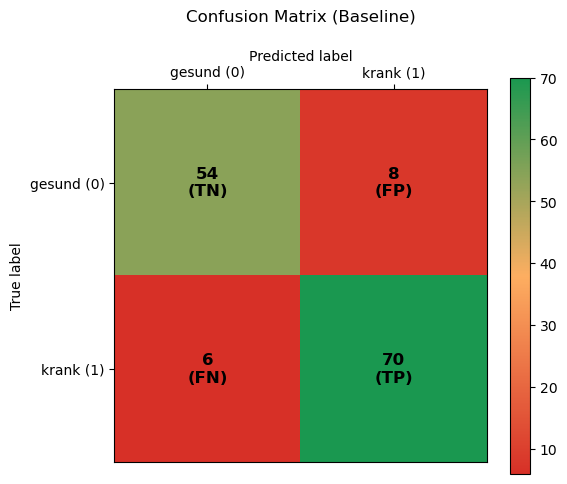

In [8]:
from matplotlib.colors import LinearSegmentedColormap

cmap_traffic = LinearSegmentedColormap.from_list(
    "traffic_light",
    ["#d73027", "#fdae61", "#1a9850"]  # rot, orange, grün
)

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

cm = np.array([[54, 8],
               [6, 70]])

labels = ["gesund (0)", "krank (1)"]

# Colormap
cmap_traffic = LinearSegmentedColormap.from_list(
    "traffic_light",
    ["#d73027", "#fdae61", "#1a9850"]
)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap=cmap_traffic)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):

        if i == 0 and j == 0:
            label = "(TN)"
        elif i == 0 and j == 1:
            label = "(FP)"
        elif i == 1 and j == 0:
            label = "(FN)"
        elif i == 1 and j == 1:
            label = "(TP)"

        ax.text(
            j, i,
            f"{cm[i, j]}\n{label}",
            ha="center", va="center",
            color="black",
            fontsize=12,
            fontweight="bold"
        )


# Achsenbeschriftung
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)

# X-Achse nach oben
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion Matrix (Baseline)", pad=20)

# Colorbar
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()


---

### Identifikation und Charakterisierung kritischer Fehlklassifikationen


In [9]:
# Klassen-Vorhersagen (Standard-Schwelle 0.5)
y_pred = rf_model.predict(X_test_processed)

# Wahrscheinlichkeiten (für später, z. B. XAI)
y_proba = rf_model.predict_proba(X_test_processed)[:, 1]

#### False Negatives (Untersuchungsobjekt)

In [10]:
# False Negatives: krank (1), aber als gesund (0) vorhergesagt
fn_mask = (y_test == 1) & (y_pred == 0)

# Anzahl False Negatives
num_fn = int(np.sum(fn_mask))
print("Anzahl False Negatives:", num_fn)

Anzahl False Negatives: 6


In [11]:
fn_cases = X_test_processed[fn_mask].copy()
fn_cases["y_true"] = y_test[fn_mask].values
fn_cases["y_pred"] = y_pred[fn_mask]
fn_cases["y_proba"] = y_proba[fn_mask]
display(fn_cases)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,...,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,y_true,y_pred,y_proba
684,47.0,108.0,243.0,0.0,152.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0,0.00
889,59.0,134.0,204.0,0.0,162.0,0.8,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0,0.08
759,54.0,192.0,283.0,0.0,195.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0,0.21
763,58.0,132.0,224.0,0.0,173.0,3.2,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0,0.25
440,52.0,128.0,0.0,0.0,180.0,3.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1,0,0.41
1,49.0,160.0,180.0,0.0,156.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1,0,0.27


#### True Positives (Referenz)

In [12]:

# True Positives: krank (1) und korrekt als krank vorhergesagt
tp_mask = (y_test == 1) & (y_pred == 1)

# Anzahl True Positives
num_tp = int(np.sum(tp_mask))
print("Anzahl True Positives:", num_tp)

Anzahl True Positives: 70


In [13]:
tp_cases = X_test_processed[tp_mask].copy()
tp_cases["y_true"] = y_test[tp_mask].values
tp_cases["y_pred"] = y_pred[tp_mask]
tp_cases["y_proba"] = y_proba[tp_mask]
display(tp_cases)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,...,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,y_true,y_pred,y_proba
615,70.0,130.0,322.0,0.0,109.0,2.4,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,1,0.67
383,38.0,110.0,0.0,0.0,156.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1,1,0.67
316,57.0,105.0,0.0,1.0,148.0,0.3,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1,1,0.69
351,43.0,140.0,0.0,0.0,140.0,0.5,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.76
546,48.0,132.0,220.0,1.0,162.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1,1,0.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,54.0,136.0,220.0,0.0,140.0,3.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1,1,1.00
313,34.0,115.0,0.0,1.0,154.0,0.2,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,0.59
238,48.0,160.0,355.0,0.0,99.0,2.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1,1,0.98
242,55.0,160.0,292.0,1.0,143.0,2.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1,1,0.92


In [14]:
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

display(tp_cases)



,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,y_true,y_pred,y_proba
615,70.0,130.0,322.0,0.0,109.0,2.4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,1,0.67
383,38.0,110.0,0.0,0.0,156.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1,1,0.67
316,57.0,105.0,0.0,1.0,148.0,0.3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1,1,0.69
351,43.0,140.0,0.0,0.0,140.0,0.5,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.76
546,48.0,132.0,220.0,1.0,162.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1,1,0.68
132,56.0,170.0,388.0,0.0,122.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1,1,0.97
481,69.0,140.0,0.0,1.0,118.0,2.5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1,1,0.72
622,59.0,110.0,239.0,0.0,142.0,1.2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1,1,0.84
398,52.0,165.0,0.0,1.0,122.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1,1,0.75
596,57.0,122.0,264.0,0.0,100.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,1,0.82


#### Vergleich der vorhergesagten Krankheitswahrscheinlichkeiten (FN vs. TP)

In [15]:
print("FN y_proba summary:")
print(fn_cases["y_proba"].describe())

print("\nTP y_proba summary:")
print(tp_cases["y_proba"].describe())

FN y_proba summary:
count    6.000000
mean     0.203333
std      0.145556
min      0.000000
25%      0.112500
50%      0.230000
75%      0.265000
max      0.410000
Name: y_proba, dtype: float64

TP y_proba summary:
count    70.000000
mean      0.833429
std       0.136529
min       0.530000
25%       0.720000
50%       0.845000
75%       0.967500
max       1.000000
Name: y_proba, dtype: float64


Die y_proba-Verteilungen zeigen eine starke Trennung: True Positives liegen fast immer deutlich über 0.5 (Median ≈ 0.845), während die wenigen False Negatives sehr niedrige Krankheitswahrscheinlichkeiten erhalten (Max ≈ 0.41). Damit sind die False Negatives keine reinen Grenzfälle, sondern Fälle, bei denen das Modell das Risiko strukturell unterschätzt – ein guter Ausgangspunkt für lokale XAI-Erklärungen und anschließende Modellanpassungen (z. B. class_weight, Feature-Logik).

---

### Baseline-Metriken

In [16]:
from sklearn.metrics import recall_score, accuracy_score, precision_score, fbeta_score

recall = recall_score(y_test, y_pred, pos_label=1)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
f2 = fbeta_score(y_test, y_pred, beta=2, pos_label=1)

print("Recall (HeartDisease = 1):", round(recall, 4))
print("Precision (HeartDisease = 1):", round(precision, 4))
print("F2-Score (HeartDisease = 1):", round(f2, 4))
print("Accuracy:", round(accuracy, 4))

Recall (HeartDisease = 1): 0.9211
Precision (HeartDisease = 1): 0.8974
F2-Score (HeartDisease = 1): 0.9162
Accuracy: 0.8986


---

# Phase 4: Globales XAI

---

# Phase 5: Lokales XAI

## Auswahl der Vergleichsgruppen

Um lokale Erklärungen besser interpretieren zu können, vergleichen wir False-Negative-Fälle mit möglichst ähnlichen True-Positive-Fällen. Dadurch isolieren wir die Merkmale, die die Modellentscheidung kippen, anstatt völlig unterschiedliche Patientenprofile zu vergleichen.

In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# ============================================================
# kNN-MATCHING: FN mit ähnlichsten TP im Feature-Space
# ============================================================

# 1) Echte Feature-Spalten definieren (aus processed Matrix!)
feature_cols = X_train_processed.columns.tolist()

# numeric_features muss bei dir existieren und genau diese Spaltennamen enthalten:
num_cols = numeric_features
cat_cols = [c for c in feature_cols if c not in num_cols]

# 2) Scaler NUR auf TRAIN fitten
scaler = StandardScaler()
scaler.fit(X_train_processed[num_cols])

# 3) Hilfsfunktion: Feature-Matrix für kNN bauen (ohne y_true/y_pred/y_proba)
def build_knn_matrix(df):
    X = df[feature_cols]  # nur echte Features
    X_num = scaler.transform(X[num_cols])
    X_cat = X[cat_cols].values
    return np.hstack([X_num, X_cat])

# 4) Matrizen bauen
X_fn = build_knn_matrix(fn_cases)
X_tp = build_knn_matrix(tp_cases)

fn_idx = fn_cases.index.to_list()
tp_idx = tp_cases.index.to_list()

# 5) kNN: für jeden FN die k ähnlichsten TP finden
k = 3
nn = NearestNeighbors(n_neighbors=k, metric="euclidean")
nn.fit(X_tp)

distances, indices = nn.kneighbors(X_fn)

# 6) Ergebnis-Tabelle
rows = []
for i, fn_id in enumerate(fn_idx):
    for r in range(k):
        tp_id = tp_idx[indices[i, r]]
        rows.append({
            "fn_id": fn_id,
            "tp_id": tp_id,
            "rank": r + 1,
            "distance": float(distances[i, r]),
            "fn_proba": float(fn_cases.loc[fn_id, "y_proba"]),
            "tp_proba": float(tp_cases.loc[tp_id, "y_proba"]),
        })

knn_matches_df = pd.DataFrame(rows).sort_values(["fn_id","rank"]).reset_index(drop=True)
knn_matches_df



,fn_id,tp_id,rank,distance,fn_proba,tp_proba
0,1,264,1,2.310927,0.27,0.72
1,1,281,2,2.647454,0.27,0.97
2,1,735,3,2.779110,0.27,0.62
3,440,492,1,2.432686,0.41,0.70
4,440,735,2,3.261938,0.41,0.62
5,440,337,3,3.459791,0.41,0.69
6,684,104,1,2.391920,0.00,0.98
7,684,131,2,2.484117,0.00,0.88
8,684,735,3,2.539645,0.00,0.62
9,759,581,1,4.267965,0.21,0.74


In [18]:
# ==== Vorhersagen auf Testset (processed) ====
y_pred = rf_model.predict(X_test_processed)
y_proba = rf_model.predict_proba(X_test_processed)[:, 1]   # Wahrscheinlichkeit für Klasse 1



In [19]:
# Masken
fn_mask = (y_test == 1) & (y_pred == 0)
tp_mask = (y_test == 1) & (y_pred == 1)

# DataFrames
fn_cases = X_test_processed.loc[fn_mask].copy()
tp_cases = X_test_processed.loc[tp_mask].copy()

# Labels + proba dazupacken
fn_cases["y_true"] = y_test.loc[fn_mask].values
fn_cases["y_pred"] = y_pred[fn_mask]
fn_cases["y_proba"] = y_proba[fn_mask]

tp_cases["y_true"] = y_test.loc[tp_mask].values
tp_cases["y_pred"] = y_pred[tp_mask]
tp_cases["y_proba"] = y_proba[tp_mask]

print("FN:", fn_cases.shape[0], "TP:", tp_cases.shape[0])
display(fn_cases[["y_proba"]].describe())
display(tp_cases[["y_proba"]].describe())


FN: 6 TP: 70


,y_proba
count,6.000000
mean,0.203333
std,0.145556
min,0.000000
25%,0.112500
50%,0.230000
75%,0.265000
max,0.410000


,y_proba
count,70.000000
mean,0.833429
std,0.136529
min,0.530000
25%,0.720000
50%,0.845000
75%,0.967500
max,1.000000


In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# Feature-Spalten = genau die Modellfeatures
feature_cols = X_train_processed.columns.tolist()

# numeric_features sind deine ORIGINAL numeric columns (vor OHE)
# In X_train_processed heißen die numeric columns i.d.R. gleich.
num_cols = [c for c in numeric_features if c in feature_cols]
cat_cols = [c for c in feature_cols if c not in num_cols]

# Scaler nur auf TRAIN fitten (Leakage vermeiden)
scaler = StandardScaler()
scaler.fit(X_train_processed[num_cols])

def build_knn_matrix(df_features_only: pd.DataFrame):
    X = df_features_only[feature_cols]
    X_num = scaler.transform(X[num_cols])
    X_cat = X[cat_cols].values
    return np.hstack([X_num, X_cat])

# Matrizen bauen (nur features, ohne Meta)
X_fn = build_knn_matrix(fn_cases[feature_cols])
X_tp = build_knn_matrix(tp_cases[feature_cols])

fn_idx = fn_cases.index.to_list()
tp_idx = tp_cases.index.to_list()

k = 3
nn = NearestNeighbors(n_neighbors=k, metric="euclidean")
nn.fit(X_tp)

distances, indices = nn.kneighbors(X_fn)

rows = []
for i, fn_id in enumerate(fn_idx):
    for r in range(k):
        tp_id = tp_idx[indices[i, r]]
        rows.append({
            "fn_id": fn_id,
            "tp_id": tp_id,
            "rank": r + 1,
            "distance": float(distances[i, r]),
            "fn_proba": float(fn_cases.loc[fn_id, "y_proba"]),
            "tp_proba": float(tp_cases.loc[tp_id, "y_proba"]),
        })

knn_matches_df = pd.DataFrame(rows).sort_values(["fn_id","rank"]).reset_index(drop=True)
display(knn_matches_df.head(15))


,fn_id,tp_id,rank,distance,fn_proba,tp_proba
0,1,264,1,2.310927,0.27,0.72
1,1,281,2,2.647454,0.27,0.97
2,1,735,3,2.779110,0.27,0.62
3,440,492,1,2.432686,0.41,0.70
4,440,735,2,3.261938,0.41,0.62
5,440,337,3,3.459791,0.41,0.69
6,684,104,1,2.391920,0.00,0.98
7,684,131,2,2.484117,0.00,0.88
8,684,735,3,2.539645,0.00,0.62
9,759,581,1,4.267965,0.21,0.74


In [21]:
import shap
import numpy as np

shap.initjs()
explainer = shap.TreeExplainer(rf_model)

shap_values = explainer.shap_values(X_test_processed)
base_value = explainer.expected_value

# --- Robust auf "list" vs "3D array" reagieren ---
if isinstance(shap_values, list):
    # klassisch: [class0, class1]
    shap_values_1 = shap_values[1]              # (n_samples, n_features)
    base_value_1 = base_value[1] if isinstance(base_value, (list, np.ndarray)) else base_value
else:
    # neu/anders: (n_samples, n_features, n_classes)
    if shap_values.ndim == 3:
        shap_values_1 = shap_values[:, :, 1]    # Klasse 1 -> (n_samples, n_features)
    else:
        shap_values_1 = shap_values             # fallback (sollte dann schon 2D sein)

    if isinstance(base_value, (list, np.ndarray)) and np.ndim(base_value) > 0:
        base_value_1 = base_value[1]
    else:
        base_value_1 = base_value



C:\Users\ayhan\anaconda3\envs\shap_clean\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
import matplotlib.pyplot as plt
import numpy as np

def get_shap_row(idx):
    row_pos = X_test_processed.index.get_loc(idx)
    x_row = X_test_processed.loc[idx]
    s_row = shap_values_1[row_pos].ravel()  # <- ravel() macht sicher 1D
    return row_pos, x_row, s_row


def plot_waterfall(idx, title):
    row_pos, x_row, s_row = get_shap_row(idx)
    exp = shap.Explanation(
        values=s_row,
        base_values=base_value_1,
        data=x_row.values,
        feature_names=X_test_processed.columns
    )
    plt.figure()
    shap.plots.waterfall(exp, max_display=15, show=False)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_decision(idxs, title):
    row_positions = [X_test_processed.index.get_loc(i) for i in idxs]
    shap_subset = shap_values_1[row_positions, :]
    X_subset = X_test_processed.loc[idxs]

    plt.figure()
    shap.decision_plot(
        base_value_1,
        shap_subset,
        X_subset,
        feature_names=X_test_processed.columns.tolist(),  # <-- FIX
        show=False
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()


def compare_fn_to_tps(fn_id, k=3):
    # passende TPs holen
    matches = knn_matches_df[knn_matches_df["fn_id"] == fn_id].sort_values("rank").head(k)
    tp_ids = matches["tp_id"].tolist()

    print("FN:", fn_id, "proba:", float(fn_cases.loc[fn_id, "y_proba"]))
    display(matches)

    # 1) Waterfall für FN
    plot_waterfall(fn_id, f"FN {fn_id} (p={fn_cases.loc[fn_id,'y_proba']:.3f})")

    # 2) Waterfall für die k ähnlichsten TP
    for tp_id in tp_ids:
        plot_waterfall(tp_id, f"TP {tp_id} (p={tp_cases.loc[tp_id,'y_proba']:.3f})")

    # 3) Decision plot: FN und seine TPs gemeinsam
    plot_decision([fn_id] + tp_ids, f"Decision Plot: FN {fn_id} vs {k} similar TPs")


FN: 684 proba: 0.0


,fn_id,tp_id,rank,distance,fn_proba,tp_proba
6,684,104,1,2.391920,0.0,0.98
7,684,131,2,2.484117,0.0,0.88
8,684,735,3,2.539645,0.0,0.62


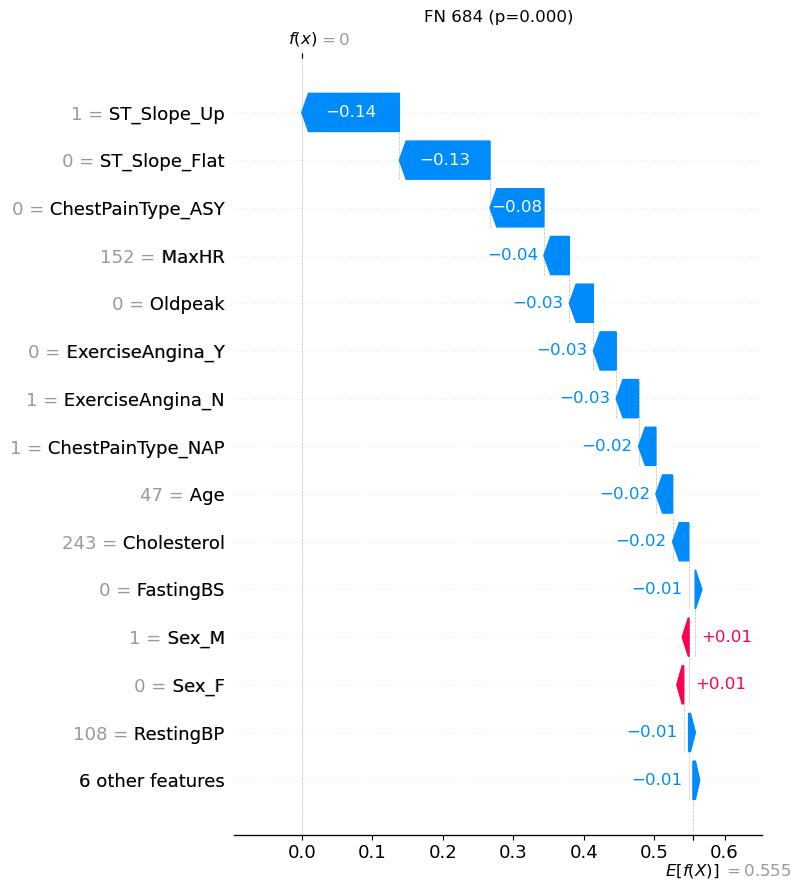

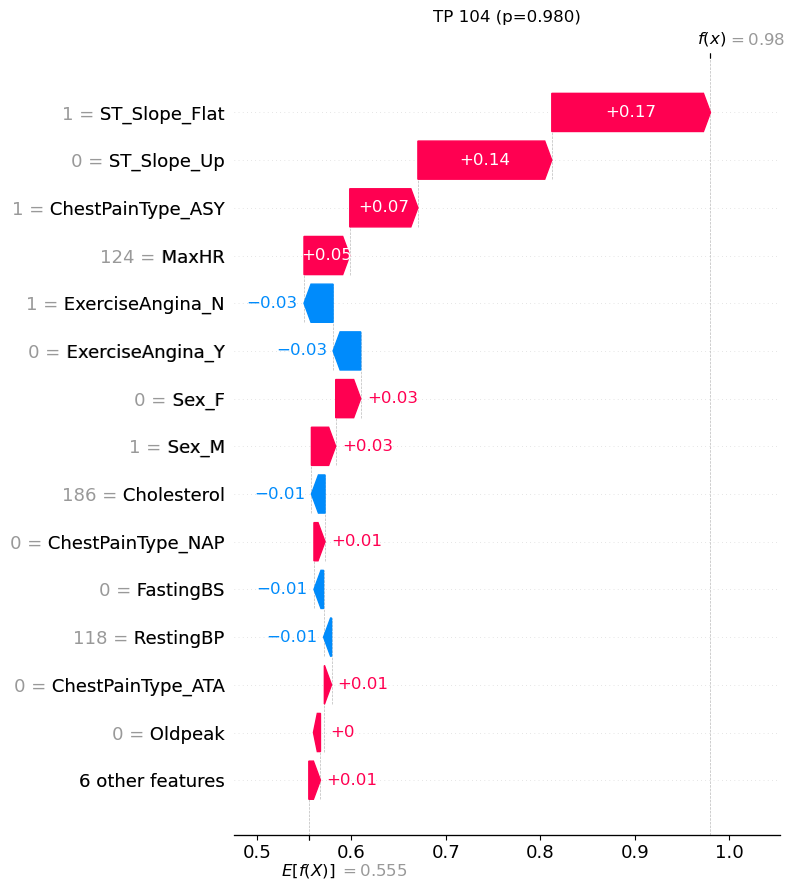

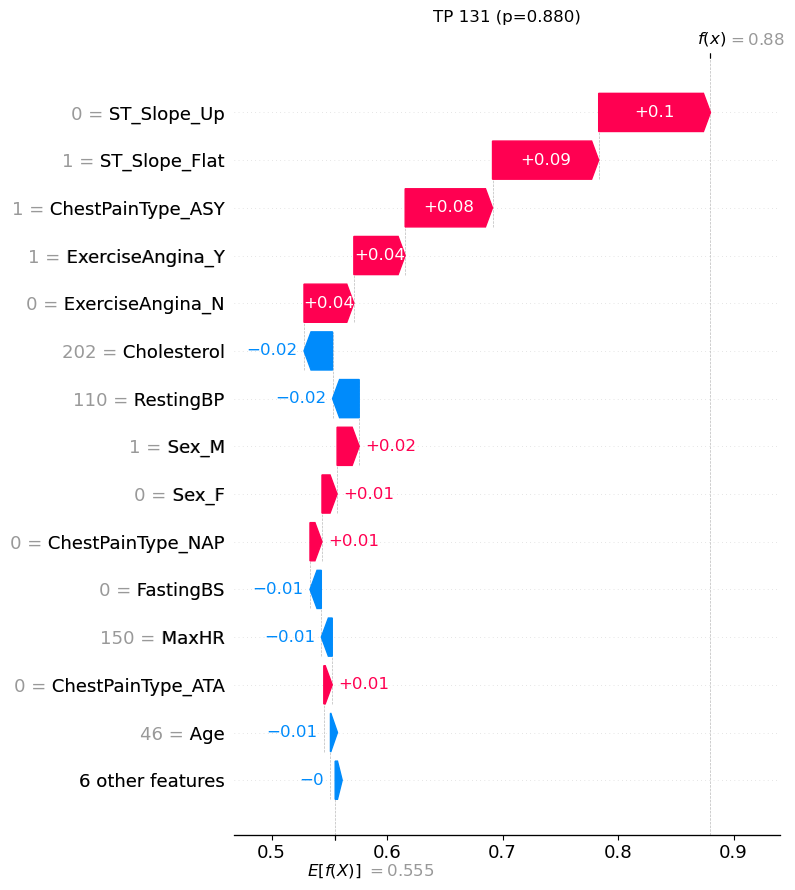

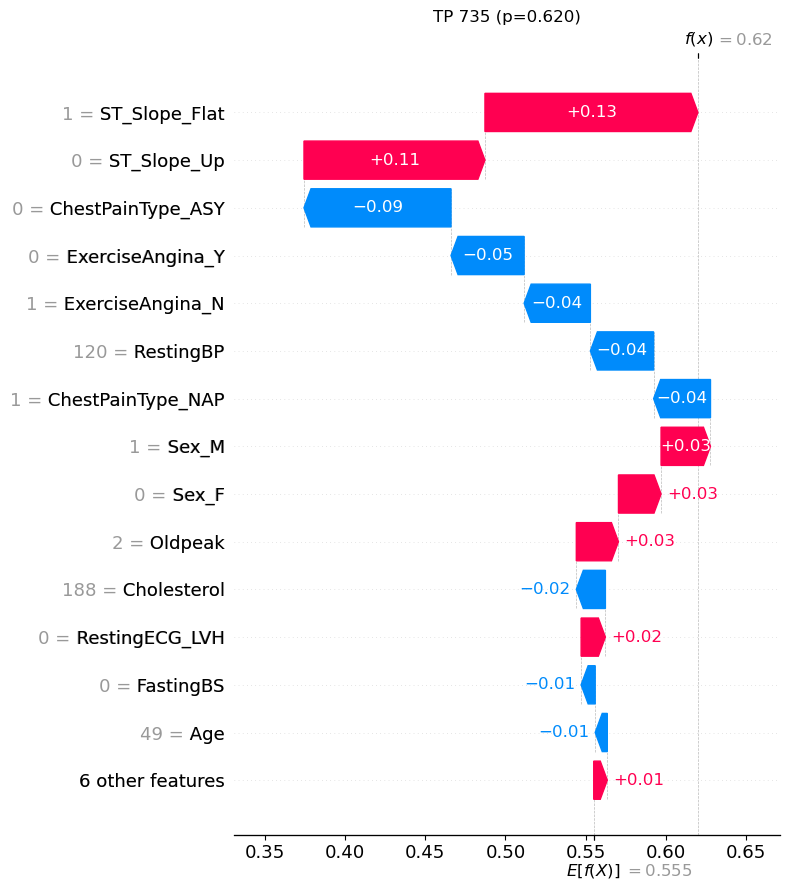

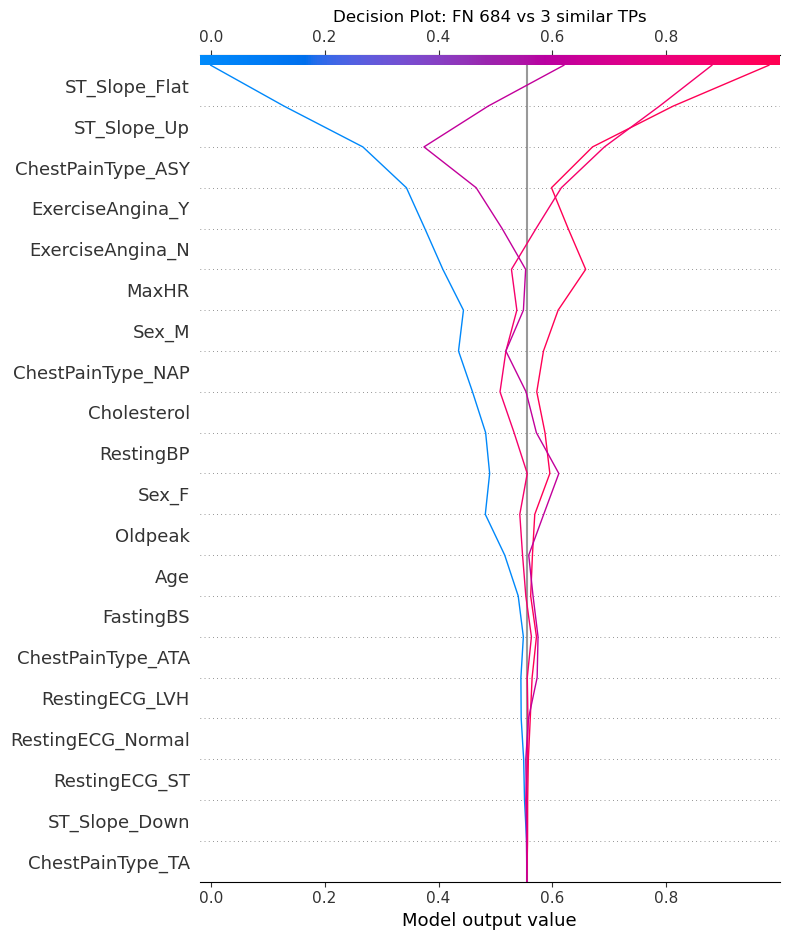

In [23]:
# Beispiel: nimm den FN mit der niedrigsten proba (oft spannend)
fn_id_example = fn_cases.sort_values("y_proba").index[0]
compare_fn_to_tps(fn_id_example, k=3)


In [28]:
def shap_top_differences(fn_id, tp_id, top_n=15):
    fn_pos = X_test_processed.index.get_loc(fn_id)
    tp_pos = X_test_processed.index.get_loc(tp_id)

    s_fn = shap_values_1[fn_pos]
    s_tp = shap_values_1[tp_pos]

    delta = s_fn - s_tp  # >0: FN hat mehr Beitrag Richtung Klasse1 als TP, <0: drückt mehr nach unten

    df = pd.DataFrame({
        "feature": X_test_processed.columns,
        "shap_fn": s_fn,
        "shap_tp": s_tp,
        "delta_fn_minus_tp": delta,
        "value_fn": X_test_processed.loc[fn_id].values,
        "value_tp": X_test_processed.loc[tp_id].values,
    })

    # Features, die beim FN stärker NACH UNTEN drücken als beim TP:
    worst = df.sort_values("delta_fn_minus_tp").head(top_n)

    # Features, die beim FN stärker NACH OBEN drücken als beim TP:
    best = df.sort_values("delta_fn_minus_tp", ascending=False).head(top_n)

    return worst, best

fn_id = int(fn_cases.sort_values("y_proba").index[0])

matches = (
    knn_matches_df
    .query("fn_id == @fn_id")
    .sort_values("rank")
)

if matches.empty:
    raise ValueError(f"Kein TP für FN {fn_id}")

tp_id = int(matches.iloc[0]["tp_id"])

worst, best = shap_top_differences(fn_id, tp_id, top_n=12)

print("Stärkste Unterschätzungs-Features (FN drückt stärker nach unten):")
display(worst)

print("Stärkste Gegenrichtung (FN drückt stärker nach oben):")
display(best)



Stärkste Unterschätzungs-Features (FN drückt stärker nach unten):


,feature,shap_fn,shap_tp,delta_fn_minus_tp,value_fn,value_tp
18,ST_Slope_Flat,-0.128599,0.167908,-0.296506,0.0,1.0
19,ST_Slope_Up,-0.138489,0.141649,-0.280138,1.0,0.0
8,ChestPainType_ASY,-0.076471,0.072102,-0.148574,0.0,1.0
4,MaxHR,-0.036144,0.048412,-0.084556,152.0,124.0
5,Oldpeak,-0.034093,0.004107,-0.038200,0.0,0.0
10,ChestPainType_NAP,-0.024582,0.011751,-0.036333,1.0,0.0
0,Age,-0.023692,0.003075,-0.026767,47.0,46.0
6,Sex_F,0.007636,0.026468,-0.018832,0.0,0.0
7,Sex_M,0.008678,0.025715,-0.017037,1.0,1.0
2,Cholesterol,-0.023048,-0.014449,-0.008599,243.0,186.0


Stärkste Gegenrichtung (FN drückt stärker nach oben):


,feature,shap_fn,shap_tp,delta_fn_minus_tp,value_fn,value_tp
1,RestingBP,-0.007055,-0.008507,0.001452,108.0,118.0
3,FastingBS,-0.009037,-0.010152,0.001115,0.0,0.0
15,ExerciseAngina_N,-0.031641,-0.030780,-0.000862,1.0,1.0
11,ChestPainType_TA,-0.000405,0.001226,-0.001631,0.0,0.0
14,RestingECG_ST,-0.001494,0.001226,-0.002720,0.0,0.0
16,ExerciseAngina_Y,-0.032389,-0.029241,-0.003148,0.0,0.0
9,ChestPainType_ATA,0.004306,0.007646,-0.003341,0.0,0.0
12,RestingECG_LVH,-0.000485,0.003242,-0.003728,0.0,0.0
17,ST_Slope_Down,-0.003665,0.000195,-0.003860,0.0,0.0
13,RestingECG_Normal,-0.004363,0.003374,-0.007737,1.0,1.0


In [29]:
print("fn_id:", fn_id, "type:", type(fn_id))
print("knn fn_id dtype:", knn_matches_df["fn_id"].dtype)
print("knn rank unique:", sorted(knn_matches_df["rank"].unique())[:10])

# Wie viele Matches gibt es überhaupt für den FN?
tmp = knn_matches_df[knn_matches_df["fn_id"] == fn_id]
print("Matches for this fn_id:", len(tmp))
display(tmp.head())


fn_id: 684 type: <class 'int'>
knn fn_id dtype: int64
knn rank unique: [np.int64(1), np.int64(2), np.int64(3)]
Matches for this fn_id: 3


,fn_id,tp_id,rank,distance,fn_proba,tp_proba
6,684,104,1,2.391920,0.0,0.98
7,684,131,2,2.484117,0.0,0.88
8,684,735,3,2.539645,0.0,0.62
